In [50]:
import geopandas as gpd 
import pandas as pd
import osmnx
import contextily as cx 
import matplotlib.pyplot as plt 
from pyproj import CRS
import seaborn as sns
import numpy as np
from dateutil.parser import parse

import helper

In [76]:
df = pd.read_csv('data/monthly/24_03.csv')

gdf_stations = helper.create_stations_gdf(df)
gdf_rides = helper.create_rides_gdf(df)

/Users/niclasclassen/Code/Master/geospatial-ds-exam/helper.py:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_rides["geometry"] = df_rides.apply(


## Distribution of how long people rent a bike

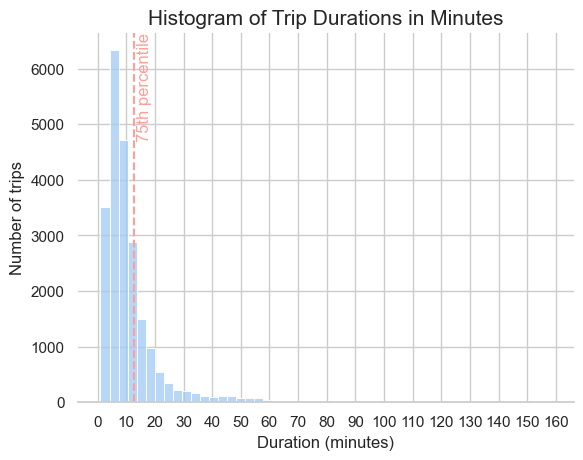

In [81]:
gdf_rides['duration_in_minutes'] = gdf_rides['duration'] / 60

# Calculate percentiles
percentiles = np.percentile(gdf_rides['duration_in_minutes'], [75])

# Set the style and color palette of the plot
sns.set_color_codes('pastel')

# Create a histogram of the duration in minutes
sns.histplot(gdf_rides['duration_in_minutes'], bins=50, color='b')

# Add vertical lines for the percentiles
for percentile in percentiles:
    plt.axvline(x=percentile, color='r', linestyle='--')
    plt.text(percentile+1, plt.gca().get_ylim()[1], '75th percentile', color='r', rotation=90, verticalalignment='top')

# Set the title and labels of the plot
plt.title('Histogram of Trip Durations in Minutes', fontsize=15)
plt.xlabel('Duration (minutes)', fontsize=12)
plt.ylabel('Number of trips', fontsize=12)

# Set x-axis labels to increments of 10
plt.xticks(np.arange(0, max(gdf_rides['duration_in_minutes'])+10, 10))

# Remove the top, right, and left spines from plot
sns.despine(left=True)

# Show the plot
plt.show()

## Number of trips during a day (start time)

In [47]:
print(gdf_rides['started_at'][1125])
print(gdf_rides['started_at'][1124])
print(gdf_rides['started_at'][1123])
print(gdf_rides['started_at'][1121])

2024-03-03 19:15:46+00:00
2024-03-03 19:13:06.702000+00:00
2024-03-03 19:13:03.774000+00:00
2024-03-03 19:12:40.249000+00:00


In [82]:
def custom_date_parser(d):
    return parse(d)

In [85]:
# Convert 'started_at' to datetime format
gdf_rides['started_at_converted'] = gdf_rides['started_at'].apply(custom_date_parser)

# Extract the hour and the day of the week
gdf_rides['day'] = gdf_rides['started_at_converted'].dt.day
gdf_rides['hour'] = gdf_rides['started_at_converted'].dt.hour
gdf_rides['day_of_week'] = gdf_rides['started_at_converted'].dt.dayofweek
gdf_rides['weekday_or_weekend'] = gdf_rides['day_of_week'].apply(lambda x: 'Weekday' if x < 5 else 'Weekend')

bins = list(range(0, 25, 1))  # Create bins for each hour
labels = [f'{i}-{i+1}' for i in bins[:-1]]  # Create labels for each bin
gdf_rides['hour_interval'] = pd.cut(gdf_rides['hour'], bins=bins, labels=labels, right=False)

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_97849/1400126263.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = gdf_rides.groupby(['day', 'hour_interval', 'weekday_or_weekend']).size().reset_index(name='num_trips')


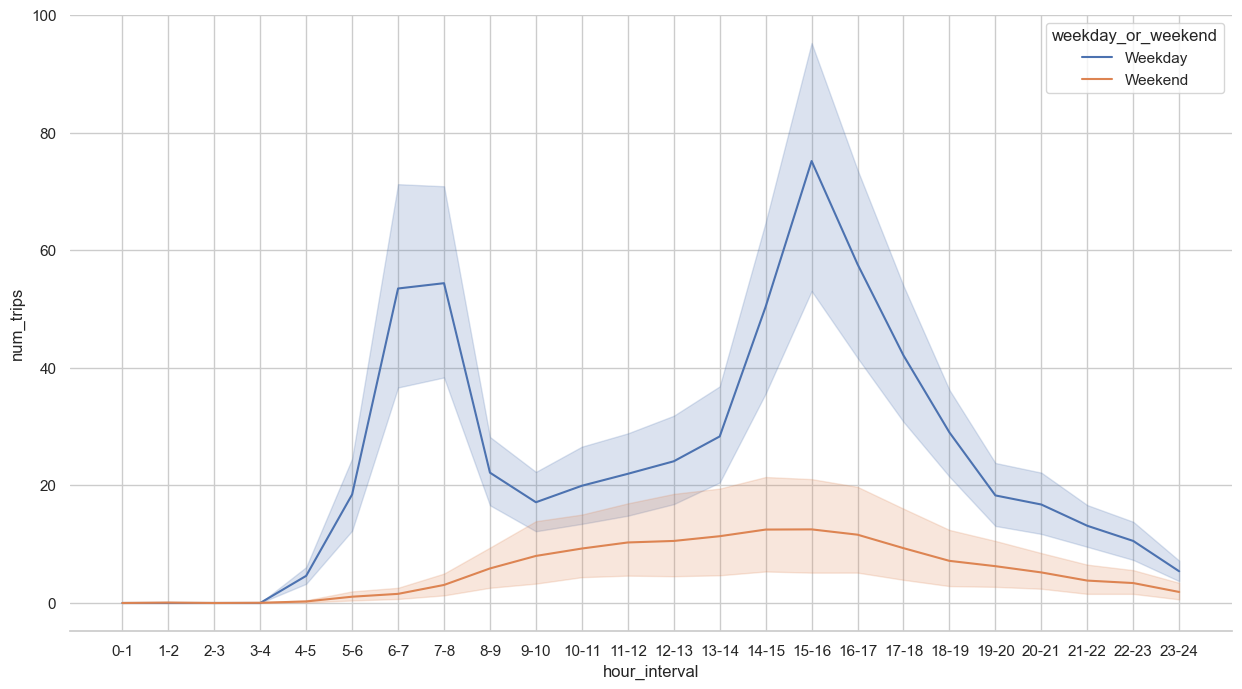

In [86]:
# Group by 'day', 'hour_interval', and 'weekday_or_weekend' and count the number of trips
grouped = gdf_rides.groupby(['day', 'hour_interval', 'weekday_or_weekend']).size().reset_index(name='num_trips')

# Create the lineplot
plt.figure(figsize=(15, 8))
sns.lineplot(data=grouped, x='hour_interval', y='num_trips', hue='weekday_or_weekend')

# Remove the top, right, and left spines from plot
sns.despine(left=True)

plt.show()

## Trip duration by weekday

/var/folders/sh/fjb1r_5j6gxcy4lzfcc4_4zr0000gn/T/ipykernel_97849/2495060029.py:9: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=gdf_rides, y='weekday', x='duration_in_minutes', ci=None, color='b', orient='h')


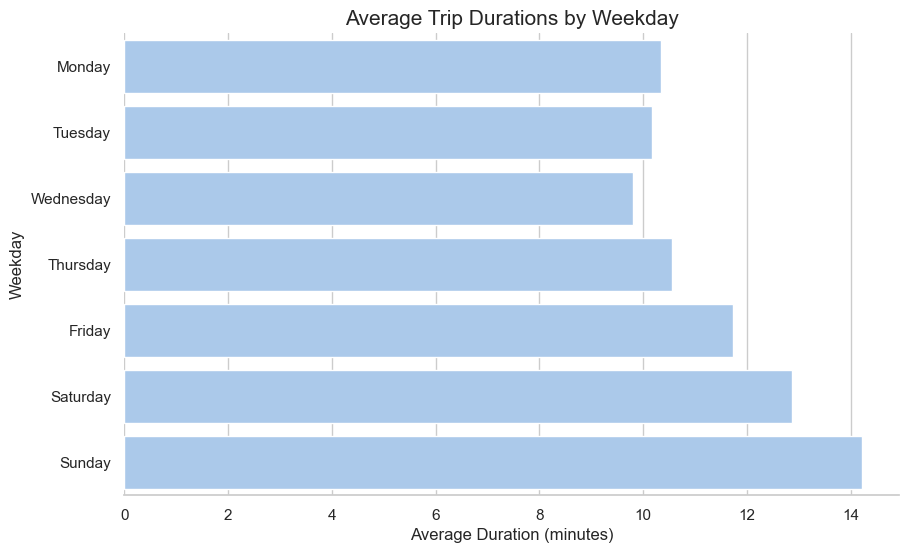

In [90]:
# Define the order of the days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

gdf_rides['weekday'] = pd.Categorical(gdf_rides['weekday'], categories=days, ordered=True)

# Create the barplot with switched axes
plt.figure(figsize=(10, 6))
sns.barplot(data=gdf_rides, y='weekday', x='duration_in_minutes', ci=None, color='b', orient='h')

# Set the title and labels of the plot
plt.title('Average Trip Durations by Weekday', fontsize=15)
plt.ylabel('Weekday', fontsize=12)
plt.xlabel('Average Duration (minutes)', fontsize=12)

# Remove the top, right, and left spines from plot
sns.despine(left=True)

# Show the plot
plt.show()